In [15]:
## This notebook includes simulation and experimental data
## in a database using PyMongo
## Author : Revathi Jambunathan
## Date : January, 2025

%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt

from Neural_Net_Classes import CombinedNN as CombinedNN
import torch
from botorch.models.transforms.input import AffineInputTransform
import pymongo
import pandas as pd
import os
import re
import yaml

In [16]:
# Select experimental setup for which we are training a model
setup = "ip2"

In [17]:
# Open credential file for database
with open(os.path.join(os.getenv('HOME'), 'db.profile')) as f:
    db_profile = f.read()

# Connect to the MongoDB database with read-only access
db = pymongo.MongoClient(
    host="mongodb05.nersc.gov",
    username="bella_sf_ro",
    password=re.findall('SF_DB_READONLY_PASSWORD=(.+)', db_profile)[0],
    authSource="bella_sf")["bella_sf"]

# Extract data from the database as pandas dataframe
collection=db[setup]
df = pd.DataFrame( list(collection.find()) )

In [18]:
# Extract the name of inputs and outputs for this setup
with open("../../config/variables.yml") as f:
    yaml_dict = yaml.safe_load( f.read() )
input_variables = yaml_dict[setup]["input_variables"]
input_names = [ v['name'] for v in input_variables.values() ] 
output_variables = yaml_dict[setup]["output_variables"]
output_names = [ v['name'] for v in output_variables.values() ]

Text(0.5, 0.5, 'z_target_um')

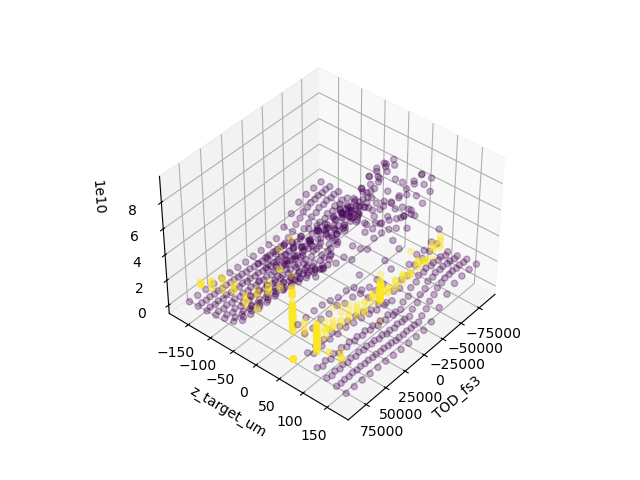

In [19]:
# Visualize the dimensional data
ax = plt.figure().add_subplot(projection='3d')

ax.scatter( 
    df[input_names[0]], 
    df[input_names[-1]], 
    df[output_names[0]], 
    c=df.experiment_flag, 
    alpha=0.3)

ax.view_init(elev=40., azim=40, roll=0)
plt.xlabel(input_names[0])
plt.ylabel(input_names[-1])

<h2> Normalize with Affine Input Transformer

In [22]:
# Define the input and output normalizations

X = torch.tensor( df[ input_names ].values, dtype=torch.float )
input_transform = AffineInputTransform( 
    len(input_names), 
    coefficient=X.std(axis=0), 
    offset=X.mean(axis=0)
)

y = torch.tensor( df[ output_names ].values, dtype=torch.float )
output_transform = AffineInputTransform( 
    len(output_names), 
    coefficient=y.std(axis=0),
    offset=y.mean(axis=0)
)

if (min(X.mean(axis=0)) == 0):
    print("Mean value used for normalization is 0. This will lead to NaNs ",X.mean(axis=0))
if (min(X.std(axis=0)) == 0):
    print("RMS value used for normalization is 0. This will lead to NaNs ", X.std(axis=0))


In [23]:
# Apply normalization to the data set
norm_df = df.copy()
norm_df[input_names] = input_transform( torch.tensor( df[input_names].values ) )
norm_df[output_names] = output_transform( torch.tensor( df[output_names].values ) )

Text(0.5, 0.5, 'z_target_um')

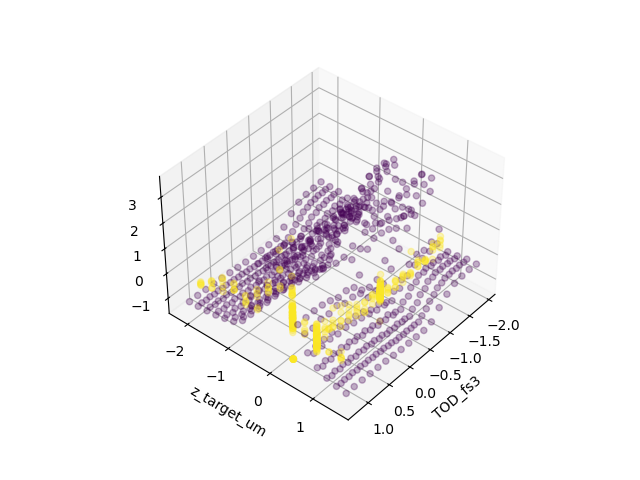

In [24]:
# Visualize the dimensional data
ax = plt.figure().add_subplot(projection='3d')

ax.scatter( 
    norm_df[input_names[0]], 
    norm_df[input_names[-1]], 
    norm_df[output_names[0]], 
    c=norm_df.experiment_flag, 
    alpha=0.3)

ax.view_init(elev=40., azim=40, roll=0)
plt.xlabel(input_names[0])
plt.ylabel(input_names[-1])

In [27]:
norm_expt_inputs_training = torch.tensor( norm_df[norm_df.experiment_flag==1][input_names].values, dtype=torch.float)
norm_expt_outputs_training = torch.tensor( norm_df[norm_df.experiment_flag==1][output_names].values, dtype=torch.float)
norm_sim_inputs_training = torch.tensor( norm_df[norm_df.experiment_flag==0][input_names].values, dtype=torch.float)
norm_sim_outputs_training = torch.tensor( norm_df[norm_df.experiment_flag==0][output_names].values, dtype=torch.float)

<h2> Train combined NN

Epoch [2000/20000], Loss:0.274741
Epoch [4000/20000], Loss:0.208208
Epoch [6000/20000], Loss:0.196222
Epoch [8000/20000], Loss:0.189632
Epoch [10000/20000], Loss:0.187948
Epoch [12000/20000], Loss:0.186757
Epoch [14000/20000], Loss:0.185823
Epoch [16000/20000], Loss:0.185536
Epoch [18000/20000], Loss:0.185536
Epoch [20000/20000], Loss:0.185536


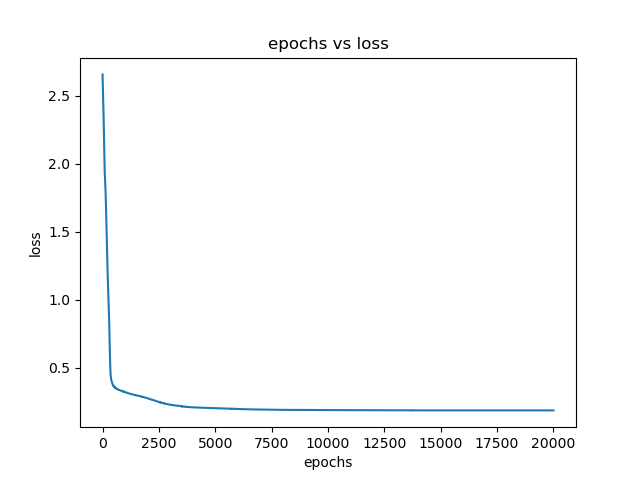

In [28]:
calibrated_nn = CombinedNN(learning_rate=0.0005)
calibrated_nn.train_model(
    norm_sim_inputs_training, norm_sim_outputs_training,
    norm_expt_inputs_training, norm_expt_outputs_training, 
    num_epochs=20000)

calibrated_nn.plot_loss()
plt.yscale('log')

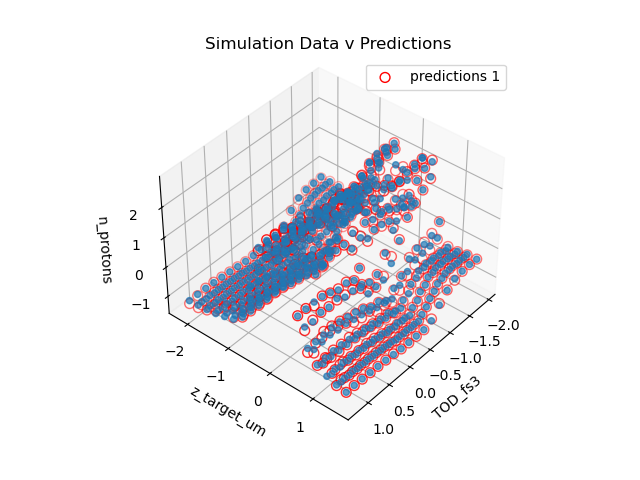

In [30]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for simulation training set
ax.scatter( 
    norm_df[norm_df.experiment_flag==0][input_names[0]], 
    norm_df[norm_df.experiment_flag==0][input_names[-1]], 
    norm_df[norm_df.experiment_flag==0][output_names[0]],  
    alpha=0.7)

# Scatter plot for the predictions
sim_train_predictions = calibrated_nn.predict_sim(norm_sim_inputs_training)
ax.scatter( 
    norm_df[norm_df.experiment_flag==0][input_names[0]], 
    norm_df[norm_df.experiment_flag==0][input_names[-1]],
    sim_train_predictions.flatten(), 
    label='predictions 1', s=50, facecolors='none', edgecolors='r')

ax.view_init(elev=40., azim=40)
# Set labels and title
ax.set_title('Simulation Data v Predictions')
ax.set_xlabel(input_names[0])
ax.set_ylabel(input_names[-1])
ax.set_zlabel(output_names[0])

# Add legend
ax.legend()
# Show plot
plt.show()

<h2> Saving the Lume Model - TO do for combined NN

In [ ]:
!pip uninstall --yes lume-model

In [ ]:
!pip install git+https://github.com/slaclab/lume-model.git@0c62723b04b78fe858a9b349433b5aacfd267f50

In [31]:
from lume_model.models import TorchModel
from lume_model.variables import ScalarVariable

In [32]:
calibration_transform = AffineInputTransform( 
    len(output_names), 
    coefficient=calibrated_nn.sim_to_exp_calibration.weight.clone(), 
    offset=calibrated_nn.sim_to_exp_calibration.bias.clone() )

In [33]:
# Fix mismatch in name between the config file and the expected lume-model format
for k in input_variables:
    print(input_variables[k])
    input_variables[k]['default_value'] = input_variables[k]['default']
    del input_variables[k]['default']
for k in output_variables:
    output_variables[k]['default_value'] = output_variables[k]['default']
    del output_variables[k]['default']    

{'name': 'TOD_fs3', 'type': 'scalar', 'default': 80000.0, 'value_range': [-80000.0, 80000.0]}
{'name': 'GVD', 'type': 'scalar', 'default': 13.6, 'value_range': [13.0, 14.0]}
{'name': 'z_target_um', 'type': 'scalar', 'default': 100.0, 'value_range': [-150.0, 150.0]}


KeyError: 'default'

In [34]:
model = TorchModel(
    model=calibrated_nn,
    input_variables=[ ScalarVariable(**input_variables[k]) for k in input_variables.keys() ],
    output_variables=[ ScalarVariable(**output_variables[k]) for k in output_variables.keys() ],
    input_transformers=[input_transform],
    output_transformers=[calibration_transform,output_transform] # saving calibration before normalization
)
model.dump( file='base_simulation_model_with_transformers_new.yml', save_jit=True )

<h2> Testing loading the model, using the interface that the dashboard uses

In [35]:
with open('./base_simulation_model_with_transformers_new.yml') as f:
    loaded_model = TorchModel(f.read());

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL Neural_Net_Classes.CombinedNN was not an allowed global by default. Please use `torch.serialization.add_safe_globals([CombinedNN])` or the `torch.serialization.safe_globals([CombinedNN])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
# Visualize the dimensional data
ax = plt.figure().add_subplot(projection='3d')

ax.scatter( 
    expt_training_set_df[input_names[0]], 
    expt_training_set_df[input_names[-1]], 
    expt_training_set_df[output_names[0]], c='g',alpha=0.3)

predictions = loaded_model.evaluate(
    { name: torch.tensor(expt_training_set_df[name].values) for name in input_names }    
)
ax.scatter( 
    expt_training_set_df[input_names[0]], 
    expt_training_set_df[input_names[-1]],
    predictions[output_names[0]], 
    label='predictions 1', s=50, facecolors='none', edgecolors='r')

ax.view_init(elev=40., azim=40, roll=0)
plt.xlabel(input_names[0])
plt.ylabel(input_names[-1])